# Variational inference for federated bandits

Toy implementation of a variational bayesian inference method for federated multi-armed bandits. The detailed description can be found in the lecture notes. Briefly, this model differs from traditional federated approaches (e.g. FedAvg) by explictly modeling uncertainty, which, in a sense, drives the aggregation of model parameters.

In [1]:
using Plots, LinearAlgebra, Zygote

In [2]:
function rbf(x₁,x₂,γ)
    d₁,d₂ = sum(x₁.^2,dims=2),sum(x₂.^2,dims=2)
    x² = x₁*x₂'
    @. exp(-γ*(-2x² + d₁ + d₂'))
end;

## Bayesian neural network/GP layer

The weights have a normal distribtion with diagonal covariance. We parameterize the distribution using natural parameters for easier computations down the line.

In [3]:
mutable struct NormalLayer
    λ1
    logλ2
end

# Constructor and operations
NormalLayer(dim) = NormalLayer(zeros(dim),zeros(dim))
Base.:+(p::NormalLayer,q::NormalLayer) = 
    NormalLayer(p.λ1 .+ q.λ1, log.(exp.(p.logλ2) .+ exp.(q.logλ2)))
Base.:-(p::NormalLayer,q::NormalLayer) = 
    NormalLayer(p.λ1 .- q.λ1, log.(max.(1e-6,exp.(p.logλ2) .- exp.(q.logλ2))))

# KL divergence
function kl(p::NormalLayer,q::NormalLayer)
    pλ2,qλ2 = exp.(p.logλ2),exp.(q.logλ2)
    sum(@. (pλ2/qλ2 + (p.λ1/pλ2-q.λ1/qλ2)^2*qλ2 - p.logλ2 + q.logλ2 - 1)/2)
end;

## Gaussian process

We use an SVGP-style variational approximation to the GP posterior, i.e. with a limited number of inducing inputs and a variational distribution $q$.

In [4]:
mutable struct GP
    Xi  # inducing points
    q   # variational params
    γ   # kernel width
    α   # KL weight
    η   # learning rate

    GP(Xi,γ;α=1e-5,η=1e-1) = new(Xi,NormalLayer(size(Xi,1)),γ,α,η)
end

## Updating the global model

First, clients compute variational updates locally via the optimization of a VAE-style ELBO, i.e. expected loss + KL divergence to a prior. The prior comes from the global model, preventing the clients from "straying too far". After the optimization is done, clients send their local updates to the global model, which take the form of statistical corrections, and automatically include statistical properties (e.g. sample sizes).

In [5]:
function update!(gp::GP,q,X,y;num_iters=1)
    q  = deepcopy(q)
    qk = deepcopy(gp.q)
    p  = q - qk

    Kff = rbf(X,X,gp.γ) + 1e-6I
    Kuf = rbf(gp.Xi,X,gp.γ)
    Kuu = rbf(gp.Xi,gp.Xi,gp.γ) + 1e-6I
    C   = Kuu\Kuf

    for i in 1:num_iters
        grad = gradient(Params([q.λ1,q.logλ2])) do
            μ  = @. q.λ1/exp(q.logλ2)
            σ² = @. 1/sqrt(exp(q.logλ2))

            fμ = C'μ
            fΣ = Kff .+ C' * (diagm(σ²) .- Kuu) * C

            L  = cholesky(Symmetric(fΣ)+1e-6I).L
            f  = fμ .+ L*randn(size(fμ))

            sum((f .- y).^2) + kl(p,q)*gp.α
        end
        
        @. q.λ1    -= gp.η*grad[q.λ1]
        @. q.logλ2 -= gp.η*grad[q.logλ2]
    end

    gp.q = q - p
    Δq   = gp.q - qk

    return Δq
end


update! (generic function with 1 method)

## Prediction with GPs

These are just the standard formulas for GP prediction in the approximate and exact settings.

In [6]:
function predict(X,Xi,q,γ)
    Kuf = rbf(Xi,X,γ)
    Kuu = rbf(Xi,Xi,γ) + 1e-6I
    C   = Kuu\Kuf

    μ   = @. q.λ1/exp(q.logλ2)
    σ²  = @. 1/sqrt(exp(q.logλ2))

    return C'μ, 1+1e-6 .+ sum(C.*(σ².*C .- Kuf),dims=1)'
end;

In [7]:
function predict_exact(X,y,x,γ,β)
    C  = rbf(X,X,γ) + β*I
    k  = rbf(X,x,γ)
    k'*(C\y),1+β .- sum(k.*(C\k),dims=1)[:]
end;

## Multi-armed bandits

Here we utilize a contextual multi-armed bandit agent with Thompson sampling. Each of the arms/reward functions are modelled by a GP; arms are chosen via posterior sampling and are updated by training the underlying GP with the reward.

In [8]:
mutable struct Bandit
    K
    gp
    
    Bandit(K,Xi,γ) = new(K,[GP(Xi,γ) for k in 1:K])
end

function choose(a::Bandit,x)
    smp = zeros(size(x,1),a.K)
    for k in 1:a.K
        μ,σ = predict(x,a.gp[k].Xi,a.gp[k].q,a.gp[k].γ)
        smp[:,k] .= (μ .+ randn(size(σ)).*σ)[:]
    end
    return argmax.(eachrow(smp))
end

function update!(a::Bandit,arms,q,x,y;num_iters=1)
    Δq = [update!(
            a.gp[k],
            q[k],
            x[arms.==k,:],
            y[arms.==k,:];
            num_iters=num_iters)
        for k in 1:a.K]
    return Δq
end

update! (generic function with 2 methods)

## Experiments

We use four arms and two agents, where each agent "sees" only a part of the input space.

In [9]:
K     = 4
γ_,β_ = 0.5,1e-5
x_  = [repeat(LinRange(-1,1,20),outer=20) repeat(LinRange(-1,1,20),inner=20)]
y_  = rand(400,K)*2
N   = 100
rt_ = LinRange(-1,1,N)
xt_ = [repeat(rt_,outer=N) repeat(rt_,inner=N)]
f_  = [predict_exact(x_,y_[:,k],xt_,γ_,β_)[1] for k in 1:K]
m_  = argmax.(eachrow(hcat(f_...)));

In [10]:
function reward(x,k)
    r = zeros(size(x,1))
    for l in 1:K
        μ,σ  = predict_exact(x_,y_[:,l],x,γ_,β_)
        r_   = μ .+ randn(size(σ)) .* σ
        r[k.==l] .= r_[k.==l]
    end
    r
end;

In [11]:
rs = 20
r  = LinRange(-1,1,rs)
Xi = [repeat(r,outer=rs) repeat(r,inner=rs)]
γ  = 1.0

bandit1 = Bandit(4,Xi,γ)
bandit2 = Bandit(4,Xi,γ)
q       = [NormalLayer(zeros(400),ones(400)*0.01) for k in 1:K]

for j in 1:100
    x1  = rand(100,2) .* [1,2]' .- [0,1]'
    k1  = choose(bandit1,x1)
    y1  = reward(x1,k1)
    Δq1 = update!(bandit1,k1,q,x1,y1;num_iters=10)
    
    x2  = rand(100,2) .* [1,2]' .- [1,1]'
    k2  = choose(bandit2,x2)
    y2  = reward(x2,k2)
    Δq2 = update!(bandit2,k2,q,x2,y2;num_iters=10)
    
    for k in 1:K
        q[k] += Δq1[k] + Δq2[k]
    end
end

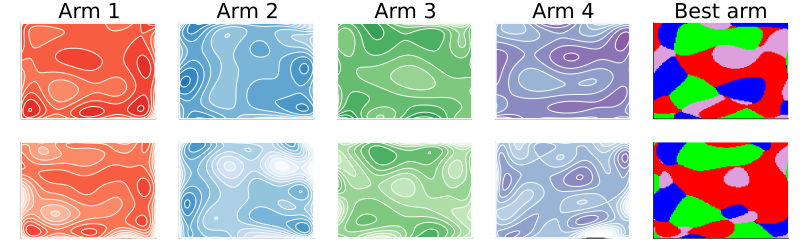

In [12]:
μ   = [predict(xt_,Xi,q[k],γ)[1] for k in 1:K]
m   = argmax.(eachrow(hcat(μ...)))

col = [:red,:blue,:lime,:plum]
p1  = contourf(rt_,rt_,reshape(f_[1],N,N),clim=(0,2),c=:Reds,title="Arm 1",ylabel="Real")
p2  = contourf(rt_,rt_,reshape(f_[2],N,N),clim=(0,2),c=:Blues,title="Arm 2")
p3  = contourf(rt_,rt_,reshape(f_[3],N,N),clim=(0,2),c=:Greens,title="Arm 3")
p4  = contourf(rt_,rt_,reshape(f_[4],N,N),clim=(0,2),c=:BuPu,title="Arm 4")
p5  = heatmap(rt_,rt_,reshape(m_,N,N),c=col,title="Best arm")

p6  = contourf(rt_,rt_,reshape(μ[1],N,N),clim=(0,2),c=:Reds,ylabel="Predicted")
p7  = contourf(rt_,rt_,reshape(μ[2],N,N),clim=(0,2),c=:Blues)
p8  = contourf(rt_,rt_,reshape(μ[3],N,N),clim=(0,2),c=:Greens)
p9  = contourf(rt_,rt_,reshape(μ[4],N,N),clim=(0,2),c=:BuPu)
p10 = heatmap(rt_,rt_,reshape(m,N,N),c=col)
plot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,layout=(2,5),cb=:none,size=(800,250),axis=nothing)